# Data visualization and budget set up

import packages

In [41]:
import sys
sys.path.append(str('/home/jupyter/All Regions/'))

from configparser import ConfigParser
import matplotlib.pyplot as plt

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

In [42]:
pd.set_option('display.float_format', '{:.6f}'.format)


initial config file to config_dict

In [43]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/All Regions/emea/June 2024 Update/config ups emea.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

05.07.2024


Query daily data

In [44]:
daily_df = GetBQData(training_query, _input, _output)
daily_df['month'] = daily_df.ds.dt.month
daily_df['year'] = daily_df.ds.dt.year


/home/jupyter/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [45]:
daily_df.ds.max()

Timestamp('2024-05-06 00:00:00')

In [46]:
daily_df.market.unique()

array(['Belgium', 'Czech', 'France', 'Germany', 'India', 'Ireland',
       'Italy', 'Netherlands', 'Poland', 'Saudi Arabia', 'Spain',
       'Sweden', 'Turkey', 'UAE', 'UK'], dtype=object)

In [47]:
pre_optimization_budget = daily_df[['year','X']].loc[(daily_df.month == 5) & (daily_df.year >= 2020)].groupby(['year']).sum().mean()


In [48]:
pre_optimization_budget

X   386683.554303
dtype: float64

In [49]:
df = daily_df.copy()
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()


In [50]:
# remove rows without date or conversion quantity
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

df = df[df.ds < cutoff_month] # ensure data is only up to cutoff_point

In [51]:
small_market_str = 'SaudiArabia|UAE|Turkey|Ireland|Sweden|Netherlands|Belgium|Czech'
updated_df = Combine(df, 'L', small_market_str)
updated_df.market.unique()

/home/jupyter/All Regions/repo/QueryingData.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_countries_ori.loc[large_countries_ori[large_countries_ori['funnel'] == 'Generic'].index, 'generic_cost'] = large_countries_ori.loc[large_countries_ori['funnel'] == 'Generic', 'X']
/home/jupyter/All Regions/repo/QueryingData.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  large_countries_ori.loc[large_countries_ori[large_countries_ori['funnel'] == 'Competitor'].index, 'competitor_cost'] = large_countri

array(['SM', 'France', 'Germany', 'Italy', 'Poland', 'Spain', 'UK',
       'India'], dtype=object)

In [52]:
#remove outliers

updated_df.drop(updated_df[(updated_df.market == 'Germany') & (updated_df.funnel == 'Non_Brand') & (updated_df.ds <'2022-01-01')].index, inplace=True)


In [53]:
updated_df

,ds,region,market,account_type,funnel,Identifier,X,y,month,year,new_funnel,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend
0,2017-08-10,Europe,SM,-,-,S,827.640008,112.000000,48.000000,12102.000000,BrandNon_BrandBrandBrandNon_BrandBrand,NaN,NaN,0.500000,0.500000,0
1,2017-08-10,Europe,France,-,Brand,L,173.279994,173.000000,8.000000,2017.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
2,2017-08-10,Europe,France,-,Non_Brand,L,1159.840001,3.000000,8.000000,2017.000000,NaN,1159.840001,0.000000,1.000000,0.000000,0
3,2017-08-10,Europe,Germany,-,Brand,L,503.510001,654.000000,16.000000,4034.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
5,2017-08-10,Europe,Italy,-,Brand,L,64.960001,117.000000,8.000000,2017.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36730,2024-04-23,Europe,Spain,-,Non_Brand,L,7.500000,3.000000,16.000000,8096.000000,NaN,0.000000,7.500000,0.000000,1.000000,0
36731,2024-04-23,Europe,UK,-,Brand,L,5927.946900,1057.000000,8.000000,4048.000000,NaN,0.000000,0.000000,0.500000,0.500000,0
36732,2024-04-23,Europe,UK,-,Non_Brand,L,50.350000,17.000000,16.000000,8096.000000,NaN,34.310000,16.040000,0.681430,0.318570,0
36733,2024-04-23,Europe,India,-,Brand,L,441.527800,193.000000,8.000000,4048.000000,NaN,0.000000,0.000000,0.500000,0.500000,0


In [54]:
df_filtered_plot = updated_df.copy()
df_filtered_plot = df_filtered_plot.loc[(df_filtered_plot['market']=='France') & (df_filtered_plot['funnel']=='Non_Brand')]
df_filtered_plot['year_month'] = df_filtered_plot.ds.dt.to_period('M')
df_filtered_plot = df_filtered_plot.groupby(['market', 'account_type', 'funnel', 'year_month']).sum(numeric_only=True).reset_index()

In [55]:
df_filtered_plot

,market,account_type,funnel,year_month,X,y,month,year,generic_cost,competitor_cost,generic_cost_split,competitor_cost_split,Weekend
0,France,-,Non_Brand,2017-08,21293.849982,100.000000,168.000000,42357.000000,21293.849982,0.000000,19.000000,3.000000,6
1,France,-,Non_Brand,2017-09,34260.779846,283.000000,270.000000,60510.000000,34260.779846,0.000000,25.500000,4.500000,9
2,France,-,Non_Brand,2017-10,54610.820239,385.000000,310.000000,62527.000000,54610.820239,0.000000,26.500000,4.500000,9
3,France,-,Non_Brand,2017-11,19531.210013,247.000000,330.000000,60510.000000,19531.210013,0.000000,30.000000,0.000000,8
4,France,-,Non_Brand,2017-12,13774.659985,99.000000,372.000000,62527.000000,13774.659985,0.000000,31.000000,0.000000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,France,-,Non_Brand,2023-12,36141.010400,1193.000000,1356.000000,228599.000000,33409.900400,2731.110000,25.617748,5.382252,10
77,France,-,Non_Brand,2024-01,2474.168300,588.000000,115.000000,232760.000000,2149.478300,324.690000,27.872961,3.127039,8
78,France,-,Non_Brand,2024-02,11259.881000,709.000000,216.000000,218592.000000,10837.661000,422.220000,27.609291,1.390709,8
79,France,-,Non_Brand,2024-03,29975.794900,600.000000,342.000000,230736.000000,28467.624900,1508.170000,29.587440,1.412560,10


In [56]:
# France Non_Brand
## High cost 2017-2018 low CQ 2017-2019
## decreasing trend in CQ 2020-2024 very low CQ in nov 2022. 
## High peaks in cost 2021-11 2023-12 2024-3. 
## remove data before 2020 -06 
# Germany Non_Brand
## decreasing trand in CQ 2022-2024, low trough in nov 2022


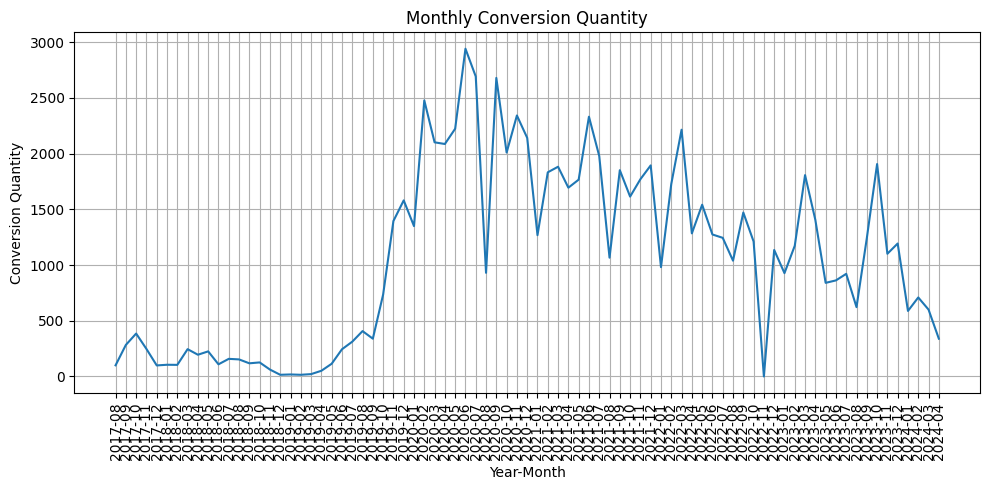

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['y'])  # Convert year_month to string for plotting
plt.title('Monthly Conversion Quantity')
plt.xlabel('Year-Month')
plt.ylabel('Conversion Quantity')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()


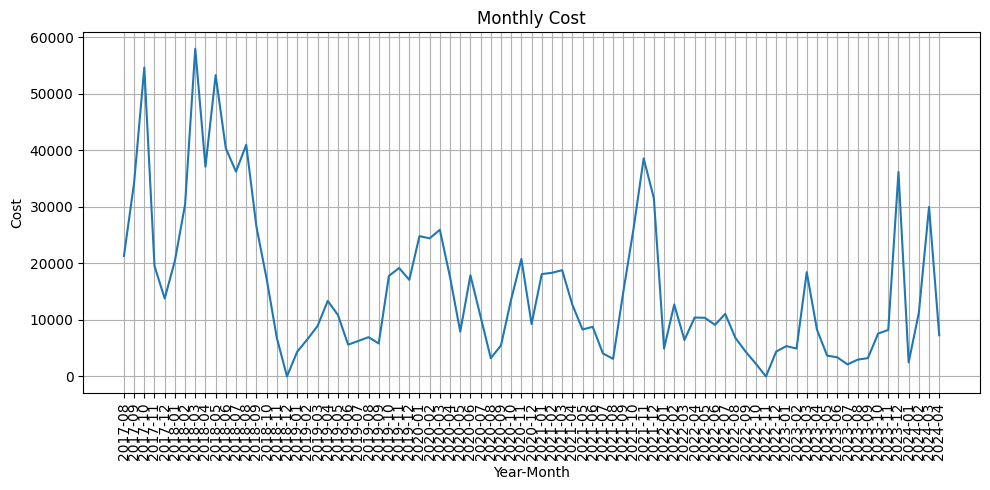

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['X'])  # Convert year_month to string for plotting
plt.title('Monthly Cost')
plt.xlabel('Year-Month')
plt.ylabel('Cost')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()
